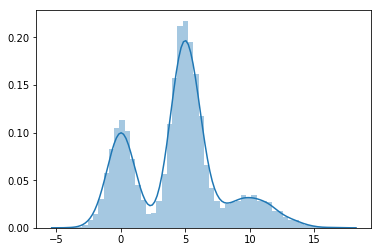

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(37)

x0 = np.random.normal(0, 1, 5000)
x1 = np.random.normal(5, 1, 10000)
x2 = np.random.normal(10, 2, 3000)
X = np.concatenate([x0, x1, x2]).reshape(-1, 1)

sns.distplot(X)

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37, n_jobs=-1)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

kms_scores = sorted([(k, get_silhouette_score(X, k)) for k in range(2, 6)], key=lambda tup: (-tup[1], tup[0]))

In [3]:
kms_scores

[(3, 0.7140940399511182),
 (2, 0.6295663291660418),
 (4, 0.599046398077821),
 (5, 0.5910863413654016)]

In [4]:
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50, random_state=37)
    gmm.fit(X)
    labels = gmm.predict(X)
    labels = np.array([0 if label == 1 else 1 for label in labels])
    return labels, gmm

labels, gmm = get_gmm_labels(X, kms_scores[0][0])

In [5]:
gmm.n_components

3

In [6]:
gmm.means_

array([[1.89046164e-03],
       [5.03204358e+00],
       [1.02046336e+01]])

In [7]:
gmm.weights_

array([0.27758279, 0.56679183, 0.15562538])

In [8]:
probs = gmm.predict_proba(X)

In [9]:
labels = np.argmax(gmm.predict_proba(X), axis=1)

In [10]:
gaussians = {}
for label in range(gmm.n_components):
    x = X.reshape(1, -1)[0][labels == label]
    mu = x.mean()
    std = x.std()
    print('{} : {}, {}'.format(label, mu, std))
    gaussians[label] = (mu, std)

0 : -0.005181915078870388, 0.9760873004276013
1 : 5.0362766911488, 1.0125108900007338
2 : 10.345674793123361, 1.706185518214973


In [11]:
from scipy.stats import dirichlet

mu_indices = np.argmax(dirichlet.rvs(gmm.weights_, size=18000, random_state=37), axis=1)

In [12]:
S = np.array([np.random.normal(gaussians[idx][0], gaussians[idx][1]) for idx in mu_indices]).reshape(-1, 1)

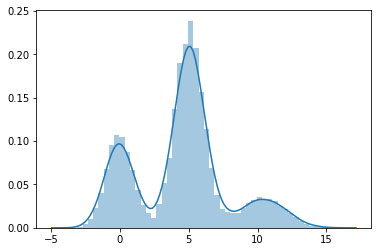

In [13]:
sns.distplot(S)

In [14]:
from scipy.stats import pearsonr

pearsonr(np.sort(S.reshape(1, -1)[0]), np.sort(X.reshape(1, -1)[0]))

(0.9991654280000528, 0.0)

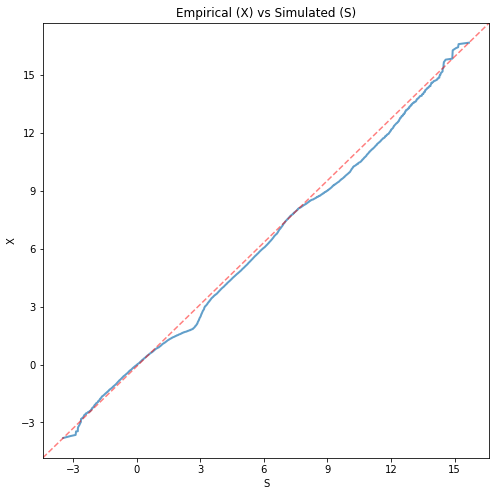

In [15]:
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.sort(S.reshape(1, -1)[0]), np.sort(X.reshape(1, -1)[0]), lw=2, alpha=0.7)
ax.set_title('Empirical (X) vs Simulated (S)')
ax.set_ylabel('X')
ax.set_xlabel('S')
ax.yaxis.set_major_locator(MaxNLocator(8))
ax.xaxis.set_major_locator(MaxNLocator(8))
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
line = mlines.Line2D([xmin, xmax], [ymin, ymax], c='red', ls='--', alpha=0.5)
ax.add_line(line)